In [1]:
%matplotlib inline


What is `torch.nn` *really*?
============================
by Jeremy Howard, `fast.ai <https://www.fast.ai>`_. Thanks to Rachel Thomas and Francisco Ingham.



We recommend running this tutorial as a notebook, not a script. To download the notebook (.ipynb) file,
click the link at the top of the page.

PyTorch provides the elegantly designed modules and classes `torch.nn <https://pytorch.org/docs/stable/nn.html>`_ ,
`torch.optim <https://pytorch.org/docs/stable/optim.html>`_ ,
`Dataset <https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset>`_ ,
and `DataLoader <https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader>`_
to help you create and train neural networks.
In order to fully utilize their power and customize
them for your problem, you need to really understand exactly what they're
doing. To develop this understanding, we will first train basic neural net
on the MNIST data set without using any features from these models; we will
initially only use the most basic PyTorch tensor functionality. Then, we will
incrementally add one feature from ``torch.nn``, ``torch.optim``, ``Dataset``, or
``DataLoader`` at a time, showing exactly what each piece does, and how it
works to make the code either more concise, or more flexible.

**This tutorial assumes you already have PyTorch installed, and are familiar
with the basics of tensor operations.** (If you're familiar with Numpy array
operations, you'll find the PyTorch tensor operations used here nearly identical).

MNIST data setup
----------------

We will use the classic `MNIST <http://deeplearning.net/data/mnist/>`_ dataset,
which consists of black-and-white images of hand-drawn digits (between 0 and 9).

We will use `pathlib <https://docs.python.org/3/library/pathlib.html>`_
for dealing with paths (part of the Python 3 standard library), and will
download the dataset using
`requests <http://docs.python-requests.org/en/master/>`_. We will only
import modules when we use them, so you can see exactly what's being
used at each point.



In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

This dataset is in numpy array format, and has been stored using pickle,
a python-specific format for serializing data.



In [3]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

Each image is 28 x 28, and is being stored as a flattened row of length
784 (=28x28). Let's take a look at one; we need to reshape it to 2d
first.



(50000, 784)
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.453125   0.9921875  0.84375    0.03515625 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.0625     0.18359375 0.61328125 0.9921875
 0.99609375 0.9921875  0.99609375 0.99609375 0.99609375 0.99609375
 0.99609375 0.99609375 0.99609375 0.99609375 0.99609375 0.99609375
 0.953125   0.98828125 0.71875    0.76953125 0.         0.
 0.         0.         0.         0.         0.25       0.11328125
 0.5234375  0.2421875  0.9140625  0.99609375 0.99609375 0.99609375
 0.99609375 0.99609375 0.99609375 0.99609375 0.99609375 0.99609375
 0.99609375 0.99609375 0.99609375 0.99609375 0.99609375 0.99609375
 0.99609375 0.99609375 0.99609375 0.64453125 0.         0.
 0.         0.         0.55078125 0.328125   0.375      0.99609375
 0.99609375 0.99609375 0.99609375 0.996

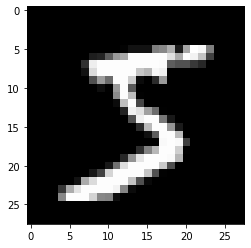

In [4]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)
print(x_train.max(0))data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAPsAAAD4CAYAAAAq5pAIAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAN9klEQVR4nO3df4xV9ZnH8c+zWP6QojBrOhKKSyEGg8ZON4gbl6w1hvojGhw1TSexoZE4/YNJaLIhNewf1WwwZBU2SzTNTKMWNl1qEzUgaQouoOzGhDgiKo5LdQ2mTEaowZEf/mCHefaPezBTnfu9w7nn3nOZ5/1Kbu6957nnnicnfDi/7pmvubsATH5/VXYDAJqDsANBEHYgCMIOBEHYgSAuaubCzIxT/0CDubuNN72uLbuZ3Wpmh8zsPTN7sJ7vAtBYlvc6u5lNkfRHSUslHZH0qqQudx9IzMOWHWiwRmzZF0t6z93fd/czkn4raVkd3weggeoJ+2xJfxrz/kg27S+YWbeZ9ZtZfx3LAlCnhp+gc/c+SX0Su/FAmerZsg9KmjPm/bezaQBaUD1hf1XSlWb2HTObKulHkrYV0xaAouXejXf3ETPrkbRD0hRJT7n724V1BqBQuS+95VoYx+xAwzXkRzUALhyEHQiCsANBEHYgCMIOBEHYgSAIOxAEYQeCIOxAEIQdCIKwA0EQdiAIwg4EQdiBIAg7EARhB4Ig7EAQhB0IgrADQRB2IAjCDgRB2IEgCDsQBGEHgiDsQBCEHQiCsANBEHYgCMIOBJF7yGZcGKZMmZKsX3rppQ1dfk9PT9XaxRdfnJx3wYIFyfrKlSuT9ccee6xqraurKznv559/nqyvW7cuWX/44YeT9TLUFXYzOyzppKSzkkbcfVERTQEoXhFb9pvc/aMCvgdAA3HMDgRRb9hd0k4ze83Musf7gJl1m1m/mfXXuSwAdah3N36Juw+a2bckvWhm/+Pue8d+wN37JPVJkpl5ncsDkFNdW3Z3H8yej0l6XtLiIpoCULzcYTezaWY2/dxrST+QdLCoxgAUq57d+HZJz5vZue/5D3f/QyFdTTJXXHFFsj516tRk/YYbbkjWlyxZUrU2Y8aM5Lz33HNPsl6mI0eOJOsbN25M1js7O6vWTp48mZz3jTfeSNZffvnlZL0V5Q67u78v6bsF9gKggbj0BgRB2IEgCDsQBGEHgiDsQBDm3rwftU3WX9B1dHQk67t3707WG32baasaHR1N1u+///5k/dSpU7mXPTQ0lKx//PHHyfqhQ4dyL7vR3N3Gm86WHQiCsANBEHYgCMIOBEHYgSAIOxAEYQeC4Dp7Adra2pL1ffv2Jevz5s0rsp1C1ep9eHg4Wb/pppuq1s6cOZOcN+rvD+rFdXYgOMIOBEHYgSAIOxAEYQeCIOxAEIQdCIIhmwtw/PjxZH316tXJ+h133JGsv/7668l6rT+pnHLgwIFkfenSpcn66dOnk/Wrr766am3VqlXJeVEstuxAEIQdCIKwA0EQdiAIwg4EQdiBIAg7EAT3s7eASy65JFmvNbxwb29v1dqKFSuS8953333J+pYtW5J1tJ7c97Ob2VNmdszMDo6Z1mZmL5rZu9nzzCKbBVC8iezG/1rSrV+Z9qCkXe5+paRd2XsALaxm2N19r6Sv/h50maRN2etNku4quC8ABcv72/h2dz83WNaHktqrfdDMuiV151wOgILUfSOMu3vqxJu790nqkzhBB5Qp76W3o2Y2S5Ky52PFtQSgEfKGfZuk5dnr5ZK2FtMOgEapuRtvZlskfV/SZWZ2RNIvJK2T9DszWyHpA0k/bGSTk92JEyfqmv+TTz7JPe8DDzyQrD/zzDPJeq0x1tE6aobd3buqlG4uuBcADcTPZYEgCDsQBGEHgiDsQBCEHQiCW1wngWnTplWtvfDCC8l5b7zxxmT9tttuS9Z37tyZrKP5GLIZCI6wA0EQdiAIwg4EQdiBIAg7EARhB4LgOvskN3/+/GR9//79yfrw8HCyvmfPnmS9v7+/au2JJ55IztvMf5uTCdfZgeAIOxAEYQeCIOxAEIQdCIKwA0EQdiAIrrMH19nZmaw//fTTyfr06dNzL3vNmjXJ+ubNm5P1oaGhZD0qrrMDwRF2IAjCDgRB2IEgCDsQBGEHgiDsQBBcZ0fSNddck6xv2LAhWb/55vyD/fb29ibra9euTdYHBwdzL/tClvs6u5k9ZWbHzOzgmGkPmdmgmR3IHrcX2SyA4k1kN/7Xkm4dZ/q/untH9vh9sW0BKFrNsLv7XknHm9ALgAaq5wRdj5m9me3mz6z2ITPrNrN+M6v+x8gANFzesP9S0nxJHZKGJK2v9kF373P3Re6+KOeyABQgV9jd/ai7n3X3UUm/krS42LYAFC1X2M1s1pi3nZIOVvssgNZQ8zq7mW2R9H1Jl0k6KukX2fsOSS7psKSfunvNm4u5zj75zJgxI1m/8847q9Zq3StvNu7l4i/t3r07WV+6dGmyPllVu85+0QRm7Bpn8pN1dwSgqfi5LBAEYQeCIOxAEIQdCIKwA0FwiytK88UXXyTrF12Uvlg0MjKSrN9yyy1Vay+99FJy3gsZf0oaCI6wA0EQdiAIwg4EQdiBIAg7EARhB4KoedcbYrv22muT9XvvvTdZv+6666rWal1Hr2VgYCBZ37t3b13fP9mwZQeCIOxAEIQdCIKwA0EQdiAIwg4EQdiBILjOPsktWLAgWe/p6UnW77777mT98ssvP++eJurs2bPJ+tBQ+q+Xj46OFtnOBY8tOxAEYQeCIOxAEIQdCIKwA0EQdiAIwg4EwXX2C0Cta9ldXeMNtFtR6zr63Llz87RUiP7+/mR97dq1yfq2bduKbGfSq7llN7M5ZrbHzAbM7G0zW5VNbzOzF83s3ex5ZuPbBZDXRHbjRyT9o7svlPR3klaa2UJJD0ra5e5XStqVvQfQomqG3d2H3H1/9vqkpHckzZa0TNKm7GObJN3VqCYB1O+8jtnNbK6k70naJ6nd3c/9OPlDSe1V5umW1J2/RQBFmPDZeDP7pqRnJf3M3U+MrXlldMhxB2109z53X+Tui+rqFEBdJhR2M/uGKkH/jbs/l00+amazsvosScca0yKAItTcjTczk/SkpHfcfcOY0jZJyyWty563NqTDSaC9fdwjnC8tXLgwWX/88ceT9auuuuq8eyrKvn37kvVHH320am3r1vQ/GW5RLdZEjtn/XtKPJb1lZgeyaWtUCfnvzGyFpA8k/bAxLQIoQs2wu/t/Sxp3cHdJNxfbDoBG4eeyQBCEHQiCsANBEHYgCMIOBMEtrhPU1tZWtdbb25uct6OjI1mfN29erp6K8MorryTr69evT9Z37NiRrH/22Wfn3RMagy07EARhB4Ig7EAQhB0IgrADQRB2IAjCDgQR5jr79ddfn6yvXr06WV+8eHHV2uzZs3P1VJRPP/20am3jxo3JeR955JFk/fTp07l6Quthyw4EQdiBIAg7EARhB4Ig7EAQhB0IgrADQYS5zt7Z2VlXvR4DAwPJ+vbt25P1kZGRZD11z/nw8HByXsTBlh0IgrADQRB2IAjCDgRB2IEgCDsQBGEHgjB3T3/AbI6kzZLaJbmkPnf/NzN7SNIDkv6cfXSNu/++xnelFwagbu4+7qjLEwn7LEmz3H2/mU2X9Jqku1QZj/2Uuz820SYIO9B41cI+kfHZhyQNZa9Pmtk7ksr90ywAztt5HbOb2VxJ35O0L5vUY2ZvmtlTZjazyjzdZtZvZv11dQqgLjV347/8oNk3Jb0saa27P2dm7ZI+UuU4/p9V2dW/v8Z3sBsPNFjuY3ZJMrNvSNouaYe7bxinPlfSdne/psb3EHagwaqFveZuvJmZpCclvTM26NmJu3M6JR2st0kAjTORs/FLJP2XpLckjWaT10jqktShym78YUk/zU7mpb6LLTvQYHXtxheFsAONl3s3HsDkQNiBIAg7EARhB4Ig7EAQhB0IgrADQRB2IAjCDgRB2IEgCDsQBGEHgiDsQBCEHQii2UM2fyTpgzHvL8umtaJW7a1V+5LoLa8ie/ubaoWm3s/+tYWb9bv7otIaSGjV3lq1L4ne8mpWb+zGA0EQdiCIssPeV/LyU1q1t1btS6K3vJrSW6nH7ACap+wtO4AmIexAEKWE3cxuNbNDZvaemT1YRg/VmNlhM3vLzA6UPT5dNobeMTM7OGZam5m9aGbvZs/jjrFXUm8Pmdlgtu4OmNntJfU2x8z2mNmAmb1tZquy6aWuu0RfTVlvTT9mN7Mpkv4oaamkI5JeldTl7gNNbaQKMzssaZG7l/4DDDP7B0mnJG0+N7SWmf2LpOPuvi77j3Kmu/+8RXp7SOc5jHeDeqs2zPhPVOK6K3L48zzK2LIvlvSeu7/v7mck/VbSshL6aHnuvlfS8a9MXiZpU/Z6kyr/WJquSm8twd2H3H1/9vqkpHPDjJe67hJ9NUUZYZ8t6U9j3h9Ra4337pJ2mtlrZtZddjPjaB8zzNaHktrLbGYcNYfxbqavDDPeMusuz/Dn9eIE3dctcfe/lXSbpJXZ7mpL8soxWCtdO/2lpPmqjAE4JGl9mc1kw4w/K+ln7n5ibK3MdTdOX01Zb2WEfVDSnDHvv51NawnuPpg9H5P0vCqHHa3k6LkRdLPnYyX38yV3P+ruZ919VNKvVOK6y4YZf1bSb9z9uWxy6etuvL6atd7KCPurkq40s++Y2VRJP5K0rYQ+vsbMpmUnTmRm0yT9QK03FPU2Scuz18slbS2xl7/QKsN4VxtmXCWvu9KHP3f3pj8k3a7KGfn/lfRPZfRQpa95kt7IHm+X3ZukLars1v2fKuc2Vkj6a0m7JL0r6T8ltbVQb/+uytDeb6oSrFkl9bZElV30NyUdyB63l73uEn01Zb3xc1kgCE7QAUEQdiAIwg4EQdiBIAg7EARhB4Ig7EAQ/w8ie3GmjcGk5QAAAABJRU5ErkJggg==
print(x_train.min(0))

PyTorch uses ``torch.tensor``, rather than numpy arrays, so we need to
convert our data.



In [5]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


Neural net from scratch (no torch.nn)
---------------------------------------------

Let's first create a model using nothing but PyTorch tensor operations. We're assuming
you're already familiar with the basics of neural networks. (If you're not, you can
learn them at `course.fast.ai <https://course.fast.ai>`_).

PyTorch provides methods to create random or zero-filled tensors, which we will
use to create our weights and bias for a simple linear model. These are just regular
tensors, with one very special addition: we tell PyTorch that they require a
gradient. This causes PyTorch to record all of the operations done on the tensor,
so that it can calculate the gradient during back-propagation *automatically*!

For the weights, we set ``requires_grad`` **after** the initialization, since we
don't want that step included in the gradient. (Note that a trailling ``_`` in
PyTorch signifies that the operation is performed in-place.)

<div class="alert alert-info"><h4>Note</h4><p>We are initializing the weights here with
   `Xavier initialisation <http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf>`_
   (by multiplying with 1/sqrt(n)).</p></div>



In [6]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch's ability to calculate gradients automatically, we can
use any standard Python function (or callable object) as a model! So
let's just write a plain matrix multiplication and broadcasted addition
to create a simple linear model. We also need an activation function, so
we'll write `log_softmax` and use it. Remember: although PyTorch
provides lots of pre-written loss functions, activation functions, and
so forth, you can easily write your own using plain python. PyTorch will
even create fast GPU or vectorized CPU code for your function
automatically.



In [7]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In the above, the ``@`` stands for the dot product operation. We will call
our function on one batch of data (in this case, 64 images).  This is
one *forward pass*.  Note that our predictions won't be any better than
random at this stage, since we start with random weights.



In [8]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-1.9873, -2.0954, -2.3140, -2.2304, -2.5471, -2.1207, -2.5905, -2.9218,
        -2.1594, -2.3960], grad_fn=<SelectBackward>) torch.Size([64, 10])


As you see, the ``preds`` tensor contains not only the tensor values, but also a
gradient function. We'll use this later to do backprop.

Let's implement negative log-likelihood to use as the loss function
(again, we can just use standard Python):



In [9]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

Let's check our loss with our random model, so we can see if we improve
after a backprop pass later.



In [10]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.2386, grad_fn=<NegBackward>)


Let's also implement a function to calculate the accuracy of our model.
For each prediction, if the index with the largest value matches the
target value, then the prediction was correct.



In [11]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

Let's check the accuracy of our random model, so we can see if our
accuracy improves as our loss improves.



In [12]:
print(accuracy(preds, yb))

tensor([0, 0, 0, 4, 9, 0, 8, 0, 5, 4, 8, 8, 0, 0, 5, 0, 9, 1, 0, 1, 0, 0, 3, 4,
        0, 0, 4, 8, 8, 4, 8, 5, 8, 8, 0, 7, 0, 0, 8, 0, 1, 1, 9, 5, 1, 8, 8, 0,
        1, 8, 0, 0, 9, 8, 8, 8, 1, 0, 2, 1, 0, 7, 0, 0])
tensor(0.2031)


We can now run a training loop.  For each iteration, we will:

- select a mini-batch of data (of size ``bs``)
- use the model to make predictions
- calculate the loss
- ``loss.backward()`` updates the gradients of the model, in this case, ``weights``
  and ``bias``.

We now use these gradients to update the weights and bias.  We do this
within the ``torch.no_grad()`` context manager, because we do not want these
actions to be recorded for our next calculation of the gradient.  You can read
more about how PyTorch's Autograd records operations
`here <https://pytorch.org/docs/stable/notes/autograd.html>`_.

We then set the
gradients to zero, so that we are ready for the next loop.
Otherwise, our gradients would record a running tally of all the operations
that had happened (i.e. ``loss.backward()`` *adds* the gradients to whatever is
already stored, rather than replacing them).

.. tip:: You can use the standard python debugger to step through PyTorch
   code, allowing you to check the various variable values at each step.
   Uncomment ``set_trace()`` below to try it out.




In [13]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        print(pred[0])
        print(yb[0])
        print(loss)
        print("\n")

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

tensor([-2.9637, -2.8148, -2.5839, -1.8434, -2.1583, -1.8423, -2.6252, -2.1342,
        -2.2261, -2.5009], grad_fn=<SelectBackward>)
tensor(5)
tensor(2.3625, grad_fn=<NegBackward>)


tensor([-1.0201, -3.1836, -2.9308, -2.1018, -2.6702, -3.2847, -1.9091, -3.1654,
        -2.8677, -2.6812], grad_fn=<SelectBackward>)
tensor(4)
tensor(1.8227, grad_fn=<NegBackward>)


tensor([-4.8766, -0.2846, -2.9965, -4.3146, -4.4530, -4.6337, -3.0682, -2.8812,
        -3.3945, -3.9495], grad_fn=<SelectBackward>)
tensor(1)
tensor(1.8129, grad_fn=<NegBackward>)


tensor([-1.0667, -6.1433, -1.6347, -2.9783, -2.2315, -2.9089, -2.0473, -3.8702,
        -3.2790, -2.8417], grad_fn=<SelectBackward>)
tensor(0)
tensor(1.5453, grad_fn=<NegBackward>)


tensor([-3.2384, -1.0432, -2.2317, -2.7842, -3.4549, -1.9403, -3.0865, -2.8703,
        -1.9865, -3.7074], grad_fn=<SelectBackward>)
tensor(6)
tensor(1.2580, grad_fn=<NegBackward>)


tensor([-1.3790, -5.5061, -2.0635, -3.9059, -3.1352, -1.3506, -1.5037, -4.2021,
     

tensor(8)
tensor(0.6721, grad_fn=<NegBackward>)


tensor([-9.3271, -0.0323, -4.8762, -5.7639, -9.4534, -6.3532, -5.2020, -7.7432,
        -4.3703, -7.5119], grad_fn=<SelectBackward>)
tensor(1)
tensor(0.2959, grad_fn=<NegBackward>)


tensor([ -8.1157, -12.3397,  -3.1888, -12.4033,  -5.7142, -10.0435,  -0.0462,
        -11.5409,  -8.6789,  -8.8519], grad_fn=<SelectBackward>)
tensor(6)
tensor(0.4452, grad_fn=<NegBackward>)


tensor([ -1.6951,  -9.4354,  -1.7590,  -3.6093,  -3.8159,  -1.5202,  -1.4712,
        -11.0738,  -1.9566,  -5.2294], grad_fn=<SelectBackward>)
tensor(8)
tensor(0.5034, grad_fn=<NegBackward>)


tensor([-2.5611, -5.7005, -3.3723, -4.7882, -2.3632, -0.9240, -5.0979, -2.1736,
        -1.7983, -2.2995], grad_fn=<SelectBackward>)
tensor(5)
tensor(0.6548, grad_fn=<NegBackward>)


tensor([-8.1766, -9.0630, -6.4783, -4.8757, -0.2844, -3.5668, -6.1010, -4.4554,
        -4.0994, -1.7187], grad_fn=<SelectBackward>)
tensor(4)
tensor(0.5672, grad_fn=<NegBackward>)


tensor([-10.248

tensor(4)
tensor(0.5077, grad_fn=<NegBackward>)


tensor([-11.1367,  -0.3987,  -5.4733,  -2.6438,  -3.1552,  -3.0858,  -3.8443,
         -3.6834,  -2.3947,  -3.5959], grad_fn=<SelectBackward>)
tensor(1)
tensor(0.5224, grad_fn=<NegBackward>)


tensor([ -3.7374, -10.5297,  -4.1249,  -8.3535,  -0.3955,  -4.7627,  -3.9090,
         -4.1928,  -2.3972,  -1.8856], grad_fn=<SelectBackward>)
tensor(4)
tensor(0.5938, grad_fn=<NegBackward>)


tensor([ -7.3402,  -9.2452,  -6.8644,  -7.1157,  -9.7224,  -5.2579,  -0.0193,
        -13.4239,  -4.5016,  -8.5699], grad_fn=<SelectBackward>)
tensor(6)
tensor(0.6917, grad_fn=<NegBackward>)


tensor([ -6.1856,  -9.7397,  -5.6616, -10.1454,  -5.7279,  -8.7660,  -0.0151,
         -9.7184,  -6.7137,  -5.3762], grad_fn=<SelectBackward>)
tensor(6)
tensor(0.3345, grad_fn=<NegBackward>)


tensor([-0.3258, -8.2734, -2.5069, -5.8010, -7.0591, -3.5420, -3.7453, -6.8287,
        -1.9777, -7.9929], grad_fn=<SelectBackward>)
tensor(6)
tensor(0.2504, grad_fn=<NegBackward

tensor([-9.2032e+00, -9.7385e+00, -5.4951e+00, -1.0325e+01, -7.4385e+00,
        -8.6105e+00, -5.4941e-03, -1.2154e+01, -8.7027e+00, -8.3441e+00],
       grad_fn=<SelectBackward>)
tensor(6)
tensor(0.2858, grad_fn=<NegBackward>)


tensor([-9.4808e+00, -1.9053e+01, -9.1248e-03, -4.7403e+00, -9.3238e+00,
        -9.2788e+00, -1.0855e+01, -1.4943e+01, -9.6287e+00, -1.2793e+01],
       grad_fn=<SelectBackward>)
tensor(2)
tensor(0.0952, grad_fn=<NegBackward>)


tensor([-1.5734e+01, -1.3808e+01, -9.7709e+00, -1.0265e+01, -6.9625e+00,
        -1.4271e+01, -1.3331e+01, -3.4275e-03, -8.1131e+00, -6.1752e+00],
       grad_fn=<SelectBackward>)
tensor(7)
tensor(0.1445, grad_fn=<NegBackward>)


tensor([-12.1734, -12.4259,  -8.3242,  -8.2914,  -0.3343,  -7.5270,  -4.8564,
         -8.5545,  -4.6585,  -1.3255], grad_fn=<SelectBackward>)
tensor(4)
tensor(0.3082, grad_fn=<NegBackward>)


tensor([ -5.7412,  -4.8198,  -0.3853,  -1.6759, -13.4331,  -6.2360,  -3.0003,
        -15.7079,  -2.6653, -11.8744], 

tensor([ -4.3988,  -9.0649, -12.6827,  -7.4543,  -8.0416,  -0.0257, -12.2618,
         -5.3613,  -4.9210, -10.4797], grad_fn=<SelectBackward>)
tensor(5)
tensor(0.3476, grad_fn=<NegBackward>)


tensor([-1.0244e+01, -1.6368e+01, -1.5717e-03, -9.5950e+00, -1.7337e+01,
        -1.0791e+01, -1.5141e+01, -1.3872e+01, -6.5400e+00, -1.9047e+01],
       grad_fn=<SelectBackward>)
tensor(2)
tensor(0.3197, grad_fn=<NegBackward>)


tensor([-13.1791,  -1.8902,  -8.1426,  -5.9325,  -4.2417,  -6.4711,  -8.7833,
         -0.2498,  -3.9152,  -3.4735], grad_fn=<SelectBackward>)
tensor(7)
tensor(0.3464, grad_fn=<NegBackward>)


tensor([-6.4538, -4.7342, -6.3621, -5.5119, -7.7235, -5.2498, -9.1275, -0.7805,
        -1.2305, -1.4795], grad_fn=<SelectBackward>)
tensor(7)
tensor(0.2426, grad_fn=<NegBackward>)


tensor([-9.5940e+00, -1.1484e+01, -1.0992e+01, -1.1742e-02, -1.2100e+01,
        -4.5946e+00, -1.4187e+01, -1.1919e+01, -6.5429e+00, -1.0922e+01],
       grad_fn=<SelectBackward>)
tensor(3)
tensor(0.27

tensor(2)
tensor(0.5329, grad_fn=<NegBackward>)


tensor([-13.7388,  -2.9537,  -0.0732,  -4.4692, -15.4590,  -9.6080,  -8.3741,
        -15.8080,  -5.0055, -11.2667], grad_fn=<SelectBackward>)
tensor(2)
tensor(0.5381, grad_fn=<NegBackward>)


tensor([ -9.1809,  -1.8514,  -0.2938,  -4.8127,  -6.8531,  -4.9832,  -2.8003,
        -11.1620,  -3.9010,  -7.7953], grad_fn=<SelectBackward>)
tensor(2)
tensor(0.2674, grad_fn=<NegBackward>)


tensor([ -6.7615, -10.6778,  -0.9004,  -6.0774,  -7.4107,  -0.9548,  -6.6601,
         -4.6964,  -1.7823,  -3.6499], grad_fn=<SelectBackward>)
tensor(2)
tensor(0.2766, grad_fn=<NegBackward>)


tensor([ -2.1977,  -5.8839,  -3.1549,  -1.9808,  -9.5111,  -0.3649,  -5.5534,
        -13.5801,  -4.9111, -13.1327], grad_fn=<SelectBackward>)
tensor(2)
tensor(0.5084, grad_fn=<NegBackward>)


tensor([-8.2984e+00, -2.6170e+01, -5.9223e-04, -9.1784e+00, -1.7270e+01,
        -1.0763e+01, -1.2542e+01, -2.2040e+01, -8.4444e+00, -2.2004e+01],
       grad_fn=<SelectBackward>

tensor(0.4435, grad_fn=<NegBackward>)


tensor([-10.5176,  -3.3722,  -2.4039,  -3.1701,  -3.1657,  -8.3049,  -5.6534,
         -0.2821,  -5.3312,  -3.5629], grad_fn=<SelectBackward>)
tensor(7)
tensor(0.2126, grad_fn=<NegBackward>)


tensor([-9.4107, -4.1566, -8.1569, -3.0143, -0.5186, -8.0198, -5.2687, -7.1109,
        -3.7469, -1.1723], grad_fn=<SelectBackward>)
tensor(4)
tensor(0.4009, grad_fn=<NegBackward>)


tensor([-10.3549,  -0.0559,  -6.0372,  -4.3976, -10.5104,  -4.9066,  -6.9067,
         -6.6471,  -3.6564,  -5.5022], grad_fn=<SelectBackward>)
tensor(1)
tensor(0.4005, grad_fn=<NegBackward>)


tensor([-1.8215e+01, -2.0169e+01, -1.1170e+01, -1.4190e+01, -2.4128e-04,
        -1.6791e+01, -9.1797e+00, -1.3422e+01, -1.2555e+01, -9.0433e+00],
       grad_fn=<SelectBackward>)
tensor(4)
tensor(0.4143, grad_fn=<NegBackward>)


tensor([ -3.3985, -12.2999,  -3.8545,  -0.3153, -17.3004,  -1.6686, -11.0922,
        -12.3404,  -3.6025, -15.4066], grad_fn=<SelectBackward>)
tensor(3)
tensor(0

tensor(7)
tensor(0.6430, grad_fn=<NegBackward>)


tensor([-1.8768e-03, -2.1914e+01, -8.9966e+00, -9.4837e+00, -1.7715e+01,
        -6.4738e+00, -9.7527e+00, -1.7037e+01, -9.5181e+00, -1.5124e+01],
       grad_fn=<SelectBackward>)
tensor(0)
tensor(0.0912, grad_fn=<NegBackward>)


tensor([ -8.5810, -18.8023, -12.3318,  -7.3024, -10.2810,  -7.7073, -15.4460,
         -0.0398,  -8.8420,  -3.2829], grad_fn=<SelectBackward>)
tensor(7)
tensor(0.5443, grad_fn=<NegBackward>)


tensor([-10.4349, -12.2027,  -7.6945,  -8.5704,  -0.0383,  -8.5775,  -6.5107,
         -7.1392,  -6.0711,  -3.4375], grad_fn=<SelectBackward>)
tensor(4)
tensor(0.3673, grad_fn=<NegBackward>)


tensor([-10.8079,  -7.8301,  -3.6330,  -2.3155,  -3.6152,  -1.2299,  -8.4026,
         -6.0760,  -0.6185,  -4.2733], grad_fn=<SelectBackward>)
tensor(8)
tensor(0.6810, grad_fn=<NegBackward>)


tensor([ -9.4916, -12.3284,  -9.3428,  -9.0887,  -0.9020,  -7.3236,  -4.9818,
         -6.4181,  -5.0779,  -0.5472], grad_fn=<SelectBackward>

tensor(0.2545, grad_fn=<NegBackward>)


tensor([-1.2620e+01, -2.3689e+01, -1.0848e+01, -1.1662e+01, -1.9233e+01,
        -1.6840e+01, -2.1939e+01, -7.6294e-05, -1.4298e+01, -1.0025e+01],
       grad_fn=<SelectBackward>)
tensor(7)
tensor(0.2603, grad_fn=<NegBackward>)


tensor([ -5.8160,  -4.1815,  -0.2019,  -4.3165, -12.6577,  -4.7035,  -6.8378,
        -10.2339,  -1.9589, -11.2668], grad_fn=<SelectBackward>)
tensor(2)
tensor(0.5391, grad_fn=<NegBackward>)


tensor([-12.0793,  -0.0519,  -5.3386,  -5.6265,  -6.9220,  -8.6574,  -6.2869,
        -10.3552,  -3.3649,  -5.3974], grad_fn=<SelectBackward>)
tensor(1)
tensor(0.7947, grad_fn=<NegBackward>)


tensor([-1.2162e+01, -1.6159e+01, -7.7347e+00, -1.0481e+01, -1.1789e-02,
        -1.0887e+01, -8.6252e+00, -8.8432e+00, -5.9377e+00, -4.7953e+00],
       grad_fn=<SelectBackward>)
tensor(4)
tensor(0.5199, grad_fn=<NegBackward>)


tensor([-12.5574, -10.0882,  -9.1797,  -7.0781,  -0.2502,  -8.6318,  -7.0229,
         -6.3179,  -3.6698,  -1.6501

tensor(0.2910, grad_fn=<NegBackward>)


tensor([-1.6184e+01, -1.1691e+01, -8.5163e+00, -1.0519e-03, -1.2610e+01,
        -1.0746e+01, -1.8757e+01, -1.1588e+01, -7.1492e+00, -1.0690e+01],
       grad_fn=<SelectBackward>)
tensor(3)
tensor(0.2293, grad_fn=<NegBackward>)


tensor([-1.0740e+01, -1.2020e+01, -9.8787e+00, -1.2189e-02, -1.1560e+01,
        -4.7018e+00, -1.5153e+01, -8.5668e+00, -5.9707e+00, -8.4960e+00],
       grad_fn=<SelectBackward>)
tensor(3)
tensor(0.6180, grad_fn=<NegBackward>)


tensor([-1.4012e+01, -1.5026e+01, -8.2019e+00, -8.5947e+00, -1.2731e+01,
        -7.6911e+00, -1.3215e+01, -1.6531e+01, -1.5898e-03, -7.3130e+00],
       grad_fn=<SelectBackward>)
tensor(8)
tensor(0.4920, grad_fn=<NegBackward>)


tensor([-1.1629e+01, -2.1774e+01, -7.5745e+00, -1.8156e+01, -1.6217e+01,
        -1.6173e+01, -5.3501e-04, -2.7049e+01, -1.1304e+01, -1.7735e+01],
       grad_fn=<SelectBackward>)
tensor(6)
tensor(0.2149, grad_fn=<NegBackward>)


tensor([-11.6059,  -8.2708,  -1.4289,  -

tensor([ -8.4651, -15.2006,  -9.6689,  -4.0736, -17.3839,  -4.8547, -14.9197,
        -11.9525,  -0.0272,  -6.3341], grad_fn=<SelectBackward>)
tensor(8)
tensor(0.2007, grad_fn=<NegBackward>)


tensor([-1.2759e+01, -1.5304e+01, -7.7895e+00, -8.2303e+00, -1.2563e+01,
        -1.0012e+01, -1.6935e+01, -1.4842e-02, -9.1575e+00, -4.2762e+00],
       grad_fn=<SelectBackward>)
tensor(7)
tensor(0.2261, grad_fn=<NegBackward>)


tensor([ -9.8691,  -8.2546,  -9.7295,  -7.4675, -10.6804,  -0.0497, -11.7372,
        -16.9847,  -3.0471, -12.6127], grad_fn=<SelectBackward>)
tensor(5)
tensor(0.3234, grad_fn=<NegBackward>)


tensor([-1.2446e+01, -9.0684e+00, -1.1494e+01, -3.0422e-04, -1.4424e+01,
        -9.0471e+00, -1.7607e+01, -1.4042e+01, -9.8012e+00, -1.5212e+01],
       grad_fn=<SelectBackward>)
tensor(3)
tensor(0.2231, grad_fn=<NegBackward>)


tensor([-1.5328e+01, -1.2084e+01, -1.4608e+01, -1.0684e+01, -6.5055e+00,
        -1.0521e+01, -1.4818e+01, -8.3156e+00, -5.4226e+00, -6.2313e-03],
       

tensor(0)
tensor(0.3686, grad_fn=<NegBackward>)


tensor([-4.4098e-03, -2.7287e+01, -1.8287e+01, -1.3269e+01, -1.3885e+01,
        -5.4573e+00, -1.1486e+01, -1.5953e+01, -9.8953e+00, -9.5515e+00],
       grad_fn=<SelectBackward>)
tensor(9)
tensor(0.4121, grad_fn=<NegBackward>)


tensor([-1.4249e+01, -1.7221e+01, -1.3901e+01, -1.0998e+01, -5.1786e+00,
        -7.9499e+00, -1.1319e+01, -8.8116e+00, -5.0531e+00, -1.2637e-02],
       grad_fn=<SelectBackward>)
tensor(9)
tensor(0.3653, grad_fn=<NegBackward>)


tensor([-1.4598e+01, -1.2545e+01, -1.0731e+01, -8.4646e+00, -9.0876e-03,
        -7.5042e+00, -7.3669e+00, -1.2112e+01, -7.0834e+00, -4.9933e+00],
       grad_fn=<SelectBackward>)
tensor(4)
tensor(0.2181, grad_fn=<NegBackward>)


tensor([ -6.1283, -15.4246,  -0.1760,  -1.8671, -10.5186, -11.6955,  -5.3885,
        -12.0394, -10.1409, -11.8991], grad_fn=<SelectBackward>)
tensor(2)
tensor(0.1608, grad_fn=<NegBackward>)


tensor([-12.8917,  -9.4204,  -6.8047,  -0.0351,  -8.6679,  -4.1379,

tensor(8)
tensor(0.6869, grad_fn=<NegBackward>)


tensor([-1.9301e+01, -1.1894e+01, -1.3956e+01, -7.7427e+00, -8.6088e+00,
        -9.2079e+00, -1.4882e+01, -1.2064e+01, -7.1834e+00, -1.4906e-03],
       grad_fn=<SelectBackward>)
tensor(9)
tensor(0.9269, grad_fn=<NegBackward>)


tensor([ -5.7444, -17.5486,  -1.6804,  -0.2118, -18.6246,  -7.7066, -13.6578,
         -8.2431,  -7.3185, -16.7353], grad_fn=<SelectBackward>)
tensor(2)
tensor(0.5416, grad_fn=<NegBackward>)


tensor([-15.7379,  -2.9363,  -0.0777,  -4.2463, -17.7609, -10.3724,  -9.2823,
        -17.8831,  -4.9312, -12.5768], grad_fn=<SelectBackward>)
tensor(2)
tensor(0.4905, grad_fn=<NegBackward>)


tensor([-10.7036,  -1.6130,  -0.3285,  -5.0010,  -7.6711,  -5.3261,  -2.9648,
        -12.6180,  -4.0755,  -9.2421], grad_fn=<SelectBackward>)
tensor(2)
tensor(0.2223, grad_fn=<NegBackward>)


tensor([ -7.9428, -11.8963,  -1.5151,  -6.9541,  -8.2125,  -0.5273,  -7.6369,
         -6.6995,  -1.7578,  -4.2482], grad_fn=<SelectBackward>

tensor([ -1.0252, -16.5066,  -0.4597,  -5.9542, -16.1940,  -5.5458,  -8.9240,
        -11.8962,  -5.7466, -14.5783], grad_fn=<SelectBackward>)
tensor(0)
tensor(0.4113, grad_fn=<NegBackward>)


tensor([-12.1071,  -4.9382,  -2.8256,  -3.9045,  -3.5638,  -9.0459,  -6.3569,
         -0.1447,  -6.0797,  -4.1572], grad_fn=<SelectBackward>)
tensor(7)
tensor(0.1738, grad_fn=<NegBackward>)


tensor([-10.9898,  -4.0175,  -8.7603,  -3.0690,  -0.5304,  -8.7609,  -5.8226,
         -7.3821,  -3.9247,  -1.1285], grad_fn=<SelectBackward>)
tensor(4)
tensor(0.3563, grad_fn=<NegBackward>)


tensor([-11.7179,  -0.0472,  -5.9455,  -4.4260, -11.7282,  -4.9986,  -7.5088,
         -7.0530,  -3.8990,  -5.7803], grad_fn=<SelectBackward>)
tensor(1)
tensor(0.3833, grad_fn=<NegBackward>)


tensor([-2.0345e+01, -2.2098e+01, -1.2060e+01, -1.5343e+01, -6.1989e-05,
        -1.8394e+01, -1.0688e+01, -1.4909e+01, -1.3886e+01, -1.0347e+01],
       grad_fn=<SelectBackward>)
tensor(4)
tensor(0.3715, grad_fn=<NegBackward>)


That's it: we've created and trained a minimal neural network (in this case, a
logistic regression, since we have no hidden layers) entirely from scratch!

Let's check the loss and accuracy and compare those to what we got
earlier. We expect that the loss will have decreased and accuracy to
have increased, and they have.



In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

Using torch.nn.functional
------------------------------

We will now refactor our code, so that it does the same thing as before, only
we'll start taking advantage of PyTorch's ``nn`` classes to make it more concise
and flexible. At each step from here, we should be making our code one or more
of: shorter, more understandable, and/or more flexible.

The first and easiest step is to make our code shorter by replacing our
hand-written activation and loss functions with those from ``torch.nn.functional``
(which is generally imported into the namespace ``F`` by convention). This module
contains all the functions in the ``torch.nn`` library (whereas other parts of the
library contain classes). As well as a wide range of loss and activation
functions, you'll also find here some convenient functions for creating neural
nets, such as pooling functions. (There are also functions for doing convolutions,
linear layers, etc, but as we'll see, these are usually better handled using
other parts of the library.)

If you're using negative log likelihood loss and log softmax activation,
then Pytorch provides a single function ``F.cross_entropy`` that combines
the two. So we can even remove the activation function from our model.



In [ ]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

Note that we no longer call ``log_softmax`` in the ``model`` function. Let's
confirm that our loss and accuracy are the same as before:



In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

Refactor using nn.Module
-----------------------------
Next up, we'll use ``nn.Module`` and ``nn.Parameter``, for a clearer and more
concise training loop. We subclass ``nn.Module`` (which itself is a class and
able to keep track of state).  In this case, we want to create a class that
holds our weights, bias, and method for the forward step.  ``nn.Module`` has a
number of attributes and methods (such as ``.parameters()`` and ``.zero_grad()``)
which we will be using.

<div class="alert alert-info"><h4>Note</h4><p>``nn.Module`` (uppercase M) is a PyTorch specific concept, and is a
   class we'll be using a lot. ``nn.Module`` is not to be confused with the Python
   concept of a (lowercase ``m``) `module <https://docs.python.org/3/tutorial/modules.html>`_,
   which is a file of Python code that can be imported.</p></div>



In [ ]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

Since we're now using an object instead of just using a function, we
first have to instantiate our model:



In [ ]:
model = Mnist_Logistic()

Now we can calculate the loss in the same way as before. Note that
``nn.Module`` objects are used as if they are functions (i.e they are
*callable*), but behind the scenes Pytorch will call our ``forward``
method automatically.



In [ ]:
print(loss_func(model(xb), yb))

Previously for our training loop we had to update the values for each parameter
by name, and manually zero out the grads for each parameter separately, like this:
::
  with torch.no_grad():
      weights -= weights.grad * lr
      bias -= bias.grad * lr
      weights.grad.zero_()
      bias.grad.zero_()


Now we can take advantage of model.parameters() and model.zero_grad() (which
are both defined by PyTorch for ``nn.Module``) to make those steps more concise
and less prone to the error of forgetting some of our parameters, particularly
if we had a more complicated model:
::
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()


We'll wrap our little training loop in a ``fit`` function so we can run it
again later.



In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

Let's double-check that our loss has gone down:



In [ ]:
print(loss_func(model(xb), yb))

Refactor using nn.Linear
-------------------------

We continue to refactor our code.  Instead of manually defining and
initializing ``self.weights`` and ``self.bias``, and calculating ``xb  @
self.weights + self.bias``, we will instead use the Pytorch class
`nn.Linear <https://pytorch.org/docs/stable/nn.html#linear-layers>`_ for a
linear layer, which does all that for us. Pytorch has many types of
predefined layers that can greatly simplify our code, and often makes it
faster too.



In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

We instantiate our model and calculate the loss in the same way as before:



In [ ]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

We are still able to use our same ``fit`` method as before.



In [ ]:
fit()

print(loss_func(model(xb), yb))

Refactor using optim
------------------------------

Pytorch also has a package with various optimization algorithms, ``torch.optim``.
We can use the ``step`` method from our optimizer to take a forward step, instead
of manually updating each parameter.

This will let us replace our previous manually coded optimization step:
::
  with torch.no_grad():
      for p in model.parameters(): p -= p.grad * lr
      model.zero_grad()

and instead use just:
::
  opt.step()
  opt.zero_grad()

(``optim.zero_grad()`` resets the gradient to 0 and we need to call it before
computing the gradient for the next minibatch.)



In [ ]:
from torch import optim

We'll define a little function to create our model and optimizer so we
can reuse it in the future.



In [ ]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

Refactor using Dataset
------------------------------

PyTorch has an abstract Dataset class.  A Dataset can be anything that has
a ``__len__`` function (called by Python's standard ``len`` function) and
a ``__getitem__`` function as a way of indexing into it.
`This tutorial <https://pytorch.org/tutorials/beginner/data_loading_tutorial.html>`_
walks through a nice example of creating a custom ``FacialLandmarkDataset`` class
as a subclass of ``Dataset``.

PyTorch's `TensorDataset <https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset>`_
is a Dataset wrapping tensors. By defining a length and way of indexing,
this also gives us a way to iterate, index, and slice along the first
dimension of a tensor. This will make it easier to access both the
independent and dependent variables in the same line as we train.



In [ ]:
from torch.utils.data import TensorDataset

Both ``x_train`` and ``y_train`` can be combined in a single ``TensorDataset``,
which will be easier to iterate over and slice.



In [ ]:
train_ds = TensorDataset(x_train, y_train)

Previously, we had to iterate through minibatches of x and y values separately:
::
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]


Now, we can do these two steps together:
::
    xb,yb = train_ds[i*bs : i*bs+bs]




In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

Refactor using DataLoader
------------------------------

Pytorch's ``DataLoader`` is responsible for managing batches. You can
create a ``DataLoader`` from any ``Dataset``. ``DataLoader`` makes it easier
to iterate over batches. Rather than having to use ``train_ds[i*bs : i*bs+bs]``,
the DataLoader gives us each minibatch automatically.



In [ ]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

Previously, our loop iterated over batches (xb, yb) like this:
::
      for i in range((n-1)//bs + 1):
          xb,yb = train_ds[i*bs : i*bs+bs]
          pred = model(xb)

Now, our loop is much cleaner, as (xb, yb) are loaded automatically from the data loader:
::
      for xb,yb in train_dl:
          pred = model(xb)



In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

Thanks to Pytorch's ``nn.Module``, ``nn.Parameter``, ``Dataset``, and ``DataLoader``,
our training loop is now dramatically smaller and easier to understand. Let's
now try to add the basic features necessary to create effecive models in practice.

Add validation
-----------------------

In section 1, we were just trying to get a reasonable training loop set up for
use on our training data.  In reality, you **always** should also have
a `validation set <https://www.fast.ai/2017/11/13/validation-sets/>`_, in order
to identify if you are overfitting.

Shuffling the training data is
`important <https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks>`_
to prevent correlation between batches and overfitting. On the other hand, the
validation loss will be identical whether we shuffle the validation set or not.
Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We'll use a batch size for the validation set that is twice as large as
that for the training set. This is because the validation set does not
need backpropagation and thus takes less memory (it doesn't need to
store the gradients). We take advantage of this to use a larger batch
size and compute the loss more quickly.



In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call ``model.train()`` before training, and ``model.eval()``
before inference, because these are used by layers such as ``nn.BatchNorm2d``
and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)



In [ ]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

Create fit() and get_data()
----------------------------------

We'll now do a little refactoring of our own. Since we go through a similar
process twice of calculating the loss for both the training set and the
validation set, let's make that into its own function, ``loss_batch``, which
computes the loss for one batch.

We pass an optimizer in for the training set, and use it to perform
backprop.  For the validation set, we don't pass an optimizer, so the
method doesn't perform backprop.



In [ ]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

``fit`` runs the necessary operations to train our model and compute the
training and validation losses for each epoch.



In [ ]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

``get_data`` returns dataloaders for the training and validation sets.



In [ ]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

Now, our whole process of obtaining the data loaders and fitting the
model can be run in 3 lines of code:



In [ ]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

You can use these basic 3 lines of code to train a wide variety of models.
Let's see if we can use them to train a convolutional neural network (CNN)!

Switch to CNN
-------------

We are now going to build our neural network with three convolutional layers.
Because none of the functions in the previous section assume anything about
the model form, we'll be able to use them to train a CNN without any modification.

We will use Pytorch's predefined
`Conv2d <https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d>`_ class
as our convolutional layer. We define a CNN with 3 convolutional layers.
Each convolution is followed by a ReLU.  At the end, we perform an
average pooling.  (Note that ``view`` is PyTorch's version of numpy's
``reshape``)



In [ ]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

`Momentum <https://cs231n.github.io/neural-networks-3/#sgd>`_ is a variation on
stochastic gradient descent that takes previous updates into account as well
and generally leads to faster training.



In [ ]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

nn.Sequential
------------------------

``torch.nn`` has another handy class we can use to simply our code:
`Sequential <https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential>`_ .
A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a
**custom layer** from a given function.  For instance, PyTorch doesn't
have a `view` layer, and we need to create one for our network. ``Lambda``
will create a layer that we can then use when defining a network with
``Sequential``.



In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

The model created with ``Sequential`` is simply:



In [ ]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Wrapping DataLoader
-----------------------------

Our CNN is fairly concise, but it only works with MNIST, because:
 - It assumes the input is a 28\*28 long vector
 - It assumes that the final CNN grid size is 4\*4 (since that's the average
pooling kernel size we used)

Let's get rid of these two assumptions, so our model works with any 2d
single channel image. First, we can remove the initial Lambda layer but
moving the data preprocessing into a generator:



In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Next, we can replace ``nn.AvgPool2d`` with ``nn.AdaptiveAvgPool2d``, which
allows us to define the size of the *output* tensor we want, rather than
the *input* tensor we have. As a result, our model will work with any
size input.



In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Let's try it out:



In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Using your GPU
---------------

If you're lucky enough to have access to a CUDA-capable GPU (you can
rent one for about $0.50/hour from most cloud providers) you can
use it to speed up your code. First check that your GPU is working in
Pytorch:



In [ ]:
print(torch.cuda.is_available())

And then create a device object for it:



In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

Let's update ``preprocess`` to move batches to the GPU:



In [ ]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

Finally, we can move our model to the GPU.



In [ ]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

You should find it runs faster now:



In [ ]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

Closing thoughts
-----------------

We now have a general data pipeline and training loop which you can use for
training many types of models using Pytorch. To see how simple training a model
can now be, take a look at the `mnist_sample` sample notebook.

Of course, there are many things you'll want to add, such as data augmentation,
hyperparameter tuning, monitoring training, transfer learning, and so forth.
These features are available in the fastai library, which has been developed
using the same design approach shown in this tutorial, providing a natural
next step for practitioners looking to take their models further.

We promised at the start of this tutorial we'd explain through example each of
``torch.nn``, ``torch.optim``, ``Dataset``, and ``DataLoader``. So let's summarize
what we've seen:

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.

